In [1]:
"""
タイタニック号沈没は1912/4/14
Moran, Mr. James == Moran, Mr. Daniel J
Johnston, Miss. Catherine Helen "Carrie"?
Johnston, Master. William Arthur Willie""?
"""
noAge = {
    'Moran, Mr. James': 28,
    'Williams, Mr. Charles Eugene': 23,
    'Masselmani, Mrs. Fatima': 22,
    'Emir, Mr. Farred Chehab': 26,
    'O\'Dwyer, Miss. Ellen "Nellie"': 22,
    'Todoroff, Mr. Lalio': 23,
    'Spencer, Mrs. William Augustus (Marie Eugenie)': 48,
    'Glynn, Miss. Mary Agatha': 18,
    'Mamee, Mr. Hanna': 20,
    'Kraeff, Mr. Theodor': None,
    'Rogers, Mr. William John': 30,
    'Lennon, Mr. Denis': 20,
    'O\'Driscoll, Miss. Bridget': 27,
    'Samaan, Mr. Youssef': 16,
    'Woolner, Mr. Hugh': 45,
    'Stewart, Mr. Albert A': 64,
    'Moubarek, Master. Gerios': 7,
    'Staneff, Mr. Ivan': 23,
    'Moutal, Mr. Rahamin Haim': 28,
    'McDermott, Miss. Brigdet Delia': 31,
    'Slocovski, Mr. Selman Francis': 20,
    'Shorney, Mr. Charles Joseph': 22,
    'Petroff, Mr. Pastcho ("Pentcho")': 29,
    'Moss, Mr. Albert Johan': 29,
    'Moran, Miss. Bertha': 28,
    'Moore, Mr. Leonard Charles': 19,
    'McMahon, Mr. Martin': 19,
    'Peter, Miss. Anna': 2,
    'Boulos, Mrs. Joseph (Sultana)': 40,
    'Olsen, Mr. Ole Martin': 27,
    'Smiljanic, Mr. Mile': 37,
    'Sage, Master. Thomas Henry': 5,
    'Chibnall, Mrs. (Edith Martha Bowerman)': 48,
    'Baumann, Mr. John D': 48,
    'Lefebre, Master. Henry Forbes': 50,
    'Sage, Miss. Constance Gladys': 7,
    'Pernot, Mr. Rene': 39,
    'Rood, Mr. Hugh Roscoe': 39,
    'O\'Brien, Mrs. Thomas (Johanna "Hannah" Godfrey)': 27,
    'Mernagh, Mr. Robert': 28,
    'Madigan, Miss. Margaret "Maggie"': 21,
    'Sage, Mr. Frederick': 16,
    'Kiernan, Mr. Philip': 22,
    'Nenkoff, Mr. Christo': 22,
    'Lefebre, Miss. Mathilde': 12,
    'Harknett, Miss. Alice Phoebe': 21,
    'Zabour, Miss. Thamine': 19,
    'Murphy, Miss. Katherine "Kate"': 18,
    'Reed, Mr. James George': 18,
    'Thorne, Mrs. Gertrude Maybelle': 37,
    'Smith, Mr. Thomas': 26,
    'Henry, Miss. Delia': 22,
    'Cairns, Mr. Alexander': 28,
    'Healy, Miss. Hanora "Nora"': 33,
    'Parkes, Mr. Francis "Frank"': 21,
    'Smith, Mr. Richard William': 57,
    'Lewy, Mr. Ervin G': 30,
    'Saalfeld, Mr. Adolphe': 47,
    'Kelly, Miss. Anna Katherine "Annie Kate"': 20,
    'McCoy, Mr. Bernard': 24,
    'Keane, Miss. Nora A': 46,
    'Williams, Mr. Howard Hugh "Harry"': 28,
    'Fleming, Miss. Margaret': 42,
    'Sage, Mr. George John Jr': 19,
    'McCoy, Miss. Agnes': 29,
    'Frauenthal, Mrs. Henry William (Clara Heinsheimer)': 42,
    'Denkoff, Mr. Mitto': 30,
    'Davison, Mrs. Thomas Henry (Mary E Finck)': 32,
    'Williams-Lambert, Mr. Fletcher Fellows': 43,
    'Yousif, Mr. Wazli': 23,
    'McGovern, Miss. Mary': 20,
    'Mockler, Miss. Helen Mary "Ellie"': 23,
    'Mockler, Miss. Helen Mary "Ellie"': 23,
    'O\'Brien, Mr. Thomas': 26,
    'Moussa, Mrs. (Mantoura Boulos)': 52,
    'Jermyn, Miss. Annie': 26,
    'Meyer, Mrs. Edgar Joseph (Leila Saks)': 25,
    'Plotcharsky, Mr. Vasil': 27,
    'Sadlier, Mr. Matthew': 19,
    'Lefebre, Miss. Ida': 3,
    'Sdycoff, Mr. Todor': 42,
    'Hart, Mr. Henry': 30,
    'Cunningham, Mr. Alfred Fleming': 21,
    'Meek, Mrs. Thomas (Annie Louise Rowley)': 32,
    'Gheorgheff, Mr. Stanio': None,
    'Wiseman, Mr. Phillippe': 53,
    'Flynn, Mr. James': 28,
    'Thorneycroft, Mrs. Percival (Florence Kate White)': 32,
    'Johannesen-Bratthammer, Mr. Bernt': 29,
    'Hagland, Mr. Ingvald Olai Olsen': 28,
    'Peduzzi, Mr. Joseph': 24,
    'Kenyon, Mrs. Frederick R (Marion)': 40,
    'O\'Connor, Mr. Maurice': 15,
    'Maisner, Mr. Simon': 34,
    'Campbell, Mr. William': 20,
    'Scanlan, Mr. James': 20,
    'Keefe, Mr. Arthur': 44,
    'Clifford, Mr. George Quincy': 40,
    'Frost, Mr. Anthony Wood "Archie"': 38,
    'Lefebre, Miss. Jeannie': 8,
    'Hagland, Mr. Konrad Mathias Reiersen': 19,
    'Yousseff, Mr. Gerious': 45,
    'Shellard, Mr. Frederick William': 55,
    'O\'Sullivan, Miss. Bridget Mary': 21,
    'Bradley, Mr. George ("George Arthur Brayton")': 37,
    'Webber, Mr. James': 66,
    'Ryan, Mr. Patrick': 32,
    'Lahoud, Mr. Sarkis': 35,
    'Kassem, Mr. Fared': 19,
    'Farthing, Mr. John': 48,
    'Toufik, Mr. Nakli': 17,
    'Peter, Mrs. Catherine (Catherine Rizk)': 23,
    'Risien, Mr. Samuel Beard': 69,
    'Padro y Manent, Mr. Julian': 26,
    'O\'Brien, Mr. Timothy': 22,
    'Robbins, Mr. Victor': 45,
    'Morrow, Mr. Thomas Rowan': 31,
    'Simmons, Mr. John': 40,
    'Meanwell, Miss. (Marion Ogden)': 62,
    'Doharr, Mr. Tannous': 28,
    'Kelly, Miss. Mary': 22,
    'Caram, Mrs. Joseph (Maria Elias)': 18,
    'Paulner, Mr. Uscher': 16,
    'Murdlin, Mr. Joseph': 22,
    'Bourke, Miss. Mary': 40,
    'Leitch, Miss. Jessie Wills': 31,
    'Boulos, Mr. Hanna': 18,
    'Slabenoff, Mr. Petco': 42,
    'Harrington, Mr. Charles H': 37,
    'Jardin, Mr. Jose Neto': 21,
    'Jardin, Mr. Jose Neto': 21, 
    'Murphy, Miss. Margaret Jane': 25,
    'Horgan, Mr. John': 22,
    'O\'Connell, Mr. Patrick D': 18,
    'Parr, Mr. William Henry Marsh': 29,
    'Thorneycroft, Mr. Percival': 36,
    'Foo, Mr. Choong': 32,
    'Willey, Mr. Edward': 20,
    'Mitkoff, Mr. Mito': 23,
    'O\'Leary, Miss. Hanora "Norah"': 16,
    'Radeff, Mr. Alexander': 27,
    'Rommetvedt, Mr. Knud Paust': 49,
    'Taylor, Mrs. Elmer Zebley (Juliet Cummins Wright)': 49,
    'Watson, Mr. Ennis Hastings': 18,
    'Peters, Miss. Katie': 27,
    'Lam, Mr. Ali': 38, 
    'Mullens, Miss. Katherine "Katie"': 21,
    'Moubarek, Master. Halim Gonios ("William George")': 4,
    'Klaber, Mr. Herman': 41,
    'McEvoy, Mr. Michael': 20,
    'Mannion, Miss. Margareth': 28,
    'Knight, Mr. Robert J': 42,
    'Ivanoff, Mr. Kanio': 20,
    'Nankoff, Mr. Minko': 32,
    'Hawksford, Mr. Walter James': 45,
    'Garfirth, Mr. John': 22,
    'Brewe, Dr. Arthur Jackson': 45,
    'Moran, Mr. Daniel J': 28,
    'Elias, Mr. Dibo': 29,
    'Tobin, Mr. Roger': 20,
    'Kilgannon, Mr. Thomas J': 21,
    'Johnston, Mr. Andrew G': 35,
    'Keane, Mr. Andrew "Andy"': 23,
    'Sage, Miss. Stella Anna': 20,
    'Hoyt, Mr. William Fisher': 43, 
    'Fry, Mr. Richard': 39,
    'Flynn, Mr. John': 48,
    'Lam, Mr. Len': 23,
    'McCormack, Mr. Thomas Joseph': 19,
    'Saad, Mr. Amin': 30,
    'Sirota, Mr. Maurice': 19,
    'Marechal, Mr. Pierre': 29,
    'Sage, Mr. Douglas Bullen': 18,
    'Goldenberg, Mrs. Samuel L (Edwiga Grabowska)': 46,
    'Razi, Mr. Raihed': 32,
    'Sage, Miss. Dorothy Edith "Dolly"': 14,
    'van Melkebeke, Mr. Philemon': 23,
    'Laleff, Mr. Kristo': 23,
    'Johnston, Miss. Catherine Helen "Carrie"': 7,

    'Ilieff, Mr. Ylio': 32,
    'Flegenheim, Mrs. Alfred (Antoinette)': 48,
    'Samaan, Mr. Elias': 17,
    'Johnston, Mrs. Andrew G (Elizabeth Lily" Watson)"': 36,
    'Roth, Miss. Sarah A': 26,
    'Hee, Mr. Ling': 24,
    'Franklin, Mr. Thomas Parham': 37,
    'Shaughnessy, Mr. Patrick': 25,
    'Mangiavacchi, Mr. Serafino Emilio': 47,
    'Davison, Mr. Thomas Henry': 32,
    'Corey, Mrs. Percy C (Mary Phyllis Elizabeth Miller)': 32,
    'Miles, Mr. Frank': 23,
    'Demetri, Mr. Marinko': 23,
    'Lamb, Mr. John Joseph': 31,
    'Khalil, Mr. Betros': 25,
    'O\'Donoghue, Ms. Bridget': 21,
    'Pedersen, Mr. Olaf': 28,
    'Guest, Mr. Robert': 22,
    'Foley, Mr. William': 20,
    'Ryan, Mr. Edward': 24,
    'Willer, Mr. Aaron (Abi Weller")"': 37,
    'Shine, Miss. Ellen Natalia': 20,
    'Thomas, Mr. John': 34,
    'Kiernan, Mr. John': 26,
    'Kennedy, Mr. John': 24,
    'McCoy, Miss. Alicia': 26,
    'Lefebre, Mrs. Frank (Frances)': 40,
    'Thomas, Mr. Charles P': 20,
    'Hilliard, Mr. Herbert Henry': 44,
    'Crafton, Mr. John Bertram': 58,
    'Matinoff, Mr. Nicola': 30,
    'Smyth, Miss. Julia': 18,
    'Pearce, Mr. Ernest': 31,
    'Cassebeer, Mrs. Henry Arthur Jr (Eleanor Genevieve Fosdick)': 36,
    'Lithman, Mr. Simon': 27,
    'Torfa, Mr. Assad': 20,
    'Lane, Mr. Patrick': 16,
    'Sage, Miss. Ada': 10,
    'Salomon, Mr. Abraham L': 43,
    'Rasmussen, Mrs. (Lena Jacobsen Solvang)': 63,
    'Murphy, Miss. Nora': 31,
    'Omont, Mr. Alfred Fernand': 29,
    'Finoli, Mr. Luigi': 41,
    'Mahon, Miss. Bridget Delia': 20,
    'Thomson, Mr. Alexander Morrison': 36,
    'Moubarek, Mrs. George (Omine Amenia" Alexander)"': 25,
    'McNeill, Miss. Bridget': 32,
    'Linehan, Mr. Michael': 21,
    'Hyman, Mr. Abraham': 34,
    'Johnston, Master. William Arthur Willie""': None,
    'Khalil, Mrs. Betros (Zahie Maria" Elias)"': 20,
    'MacKay, Mr. George William': 20,
    'Mahon, Mr. John': None,
    'Lyntakoff, Mr. Stanko': 44,
    'Chisholm, Mr. Roderick Robert Crispin': 43,
    'Warren, Mr. Charles William': 31,
    'Howard, Miss. May Elizabeth': 26,
    'Fox, Mr. Patrick': 28,
    'Lennon, Miss. Mary': 18,
    'Saade, Mr. Jean Nassr': 20,
    'Fleming, Miss. Honora': 22,
    'Franklin, Mr. Charles (Charles Fardon)': 46,
    'Mardirosian, Mr. Sarkis': 25,
    'Ford, Mr. Arthur': 23,
    'Rheims, Mr. George Alexander Lucien': 33,
    'Nasr, Mr. Mustafa': 20,
    'Samaan, Mr. Hanna': 40,
    'Malachard, Mr. Noel': 25,
    'McCarthy, Miss. Catherine Katie""': 24,
    'Sadowitz, Mr. Harry': 16,
    'Thomas, Mr. Tannous': 16,
    'Betros, Master. Seman': 10,
    'Sage, Mr. John George': 44, # Jrじゃない
    'van Billiard, Master. James William': 10,
    'Lockyer, Mr. Edward': 19,
    'O\'Keefe, Mr. Patrick': 21,
    'Sage, Mrs. John (Annie Bullen)': 44,
    'Caram, Mr. Joseph': 28,
    'O\'Connor, Mr. Patrick': 23, 
    'Risien, Mrs. Samuel (Emma)': 64,
    'Wheeler, Mr. Edwin Frederick""': 54,
    'Riordan, Miss. Johanna Hannah""': 21,
    'Naughton, Miss. Hannah': 21,
    'Spector, Mr. Woolf': 23,
    'Ware, Mr. Frederick': 35,
    'Peter, Master. Michael J': 4
}

In [2]:
perishedFamily = ['Abbing', 'Adahl', 'Adams', 'Ahlin', 'Alexander', 'Alhomaki', 'Ali', 'Allum', 'Andreasson', 'Andrew', 'Arnold-Franchi', 'Artagaveytia', 'Asim', 'Attalah', 'Augustsson', 'Badt', 'Bailey', 'Balkic', 'Banfield', 'Barbara', 'Barton', 'Bateman', 'Baumann', 'Beavan', 'Bengtsson', 'Berglund', 'Berriman', 'Betros', 'Birkeland', 'Blackwell', 'Bostandyeff', 'Boulos', 'Bourke', 'Bowen', 'Bracken', 'Braund', 'Brewe', 'Brocklebank', 'Bryhl', 'Burke', 'Butler', 'Butt', 'Byles', 'Cacic', 'Cairns', 'Calic', 'Campbell', 'Canavan', 'Cann', 'Caram', 'Carbines', 'Carlsson', 'Carrau', 'Cavendish', 'Celotti', 'Chaffee', 'Chapman', 'Charters', 'Christmann', 'Chronopoulos', 'Clifford', 'Coelho', 'Coleff', 'Coleridge', 'Collander', 'Colley', 'Connaghton', 'Connors', 'Cook', 'Cor', 'Corn', 'Coxon', 'Crease', 'Cribb', 'Culumovic', 'Cunningham', 'Dahlberg', 'Dakic', 'Danbom', 'Danoff', 'Dantcheff', 'Davidson', 'Denkoff', 'Dennis', 'Dimic', 'Doharr', 'Dooley', 'Douglas', 'Downton', 'Drazenoic', 'Duane', 'Edvardsson', 'Eitemiller', 'Eklund', 'Ekstrom', 'Elias', 'Elsbury', 'Emir', 'Fahlstrom', 'Farrell', 'Farthing', 'Fischer', 'Ford', 'Foreman', 'Fox', 'Frost', 'Fry', 'Funk', 'Fynney', 'Gale', 'Gallagher', 'Garfirth', 'Gaskell', 'Gavey', 'Gee', 'Gheorgheff', 'Giglio', 'Giles', 'Gilinski', 'Gill', 'Gillespie', 'Givard', 'Goldschmidt', 'Goncalves', 'Goodwin', 'Green', 'Greenberg', 'Gronnestad', 'Guggenheim', 'Gustafsson', 'Haas', 'Hagland', 'Hale', 'Hampe', 'Hanna', 'Hansen', 'Harknett', 'Harmer', 'Harrington', 'Harrison', 'Hassan', 'Hegarty', 'Heininen', 'Hendekovic', 'Henry', 'Hickman', 'Hodges', 'Hold', 'Holm', 'Hood', 'Horgan', 'Humblen', 'Hunt', 'Ibrahim Shawah', 'Ilmakangas', 'Isham', 'Ivanoff', 'Jardin', 'Jarvis', 'Jenkin', 'Jensen', 'Johanson', 'Johansson', 'Johnston', 'Jonkoff', 'Kallio', 'Kalvik', 'Karaic', 'Karlsson', 'Kassem', 'Keefe', 'Kent', 'Kiernan', 'Kilgannon', 'Kink', 'Kirkland', 'Klaber', 'Klasen', 'Knight', 'Kraeff', 'Kvillner', 'Lahoud', 'Lahtinen', 'Laitinen', 'Laleff', 'Larsson', 'Lefebre', 'Leinonen', 'Lemberopolous', 'Lennon', 'Leonard', 'Lester', 'Levy', 'Lewy', 'Leyson', 'Lievens', 'Lindahl', 'Lindblom', 'Lindell', 'Ling', 'Lobb', 'Long', 'Lovell', 'Lundahl', 'Mack', 'Maenpaa', 'Maisner', 'Mangan', 'Markoff', 'Markun', 'Marvin', 'Matthews', 'McCarthy', 'McEvoy', 'McKane', 'McMahon', 'McNamee', 'Meanwell', 'Meek', 'Meo', 'Mernagh', 'Millet', 'Milling', 'Mineff', 'Mionoff', 'Mitchell', 'Mitkoff', 'Moen', 'Molson', 'Montvila', 'Moore', 'Moraweck', 'Morley', 'Morrow', 'Moutal', 'Mudd', 'Murdlin', 'Myhrman', 'Naidenoff', 'Nankoff', 'Natsch', 'Nenkoff', 'Nicholls', 'Nicholson', 'Nirva', 'Norman', 'Nosworthy', 'Novel', 'Nysveen', "O'Connell", "O'Connor", "O'Sullivan", 'Odahl', 'Olsen', 'Olsson', 'Olsvigen', 'Oreskovic', 'Osen', 'Ostby', 'Otter', 'Pain', 'Palsson', 'Panula', 'Parkes', 'Parr', 'Partner', 'Pasic', 'Patchett', 'Paulner', 'Pavlovic', 'Peduzzi', 'Pekoniemi', 'Pengelly', 'Perkin', 'Pernot', 'Peters', 'Petranec', 'Petroff', 'Petterson', 'Pettersson', 'Plotcharsky', 'Ponesell', 'Porter', 'Radeff', 'Razi', 'Reed', 'Reeves', 'Rekic', 'Reuchlin', 'Rice', 'Richard', 'Ringhini', 'Rintamaki', 'Risien', 'Robbins', 'Robins', 'Roebling', 'Rogers', 'Rommetvedt', 'Rood', 'Rosblom', 'Ross', 'Rouse', 'Rush', 'Ryan', 'Saad', 'Sadlier', 'Sage', 'Salonen', 'Samaan', 'Saundercock', 'Sawyer', 'Scanlan', 'Sdycoff', 'Sedgwick', 'Sharp', 'Shellard', 'Shorney', 'Simmons', 'Sirayanian', 'Sirota', 'Sivic', 'Sivola', 'Sjostedt', 'Skoog', 'Slabenoff', 'Slemen', 'Slocovski', 'Smart', 'Smiljanic', 'Sobey', 'Soholt', 'Somerton', 'Staneff', 'Stankovic', 'Stead', 'Stewart', 'Stoytcheff', 'Strandberg', 'Strom', 'Sutehall', 'Sutton', 'Svensson', 'Theobald', 'Tikkanen', 'Tobin', 'Todoroff', 'Tomlin', 'Torber', 'Toufik', 'Troupiansky', 'Turcin', 'Turpin', 'Uruchurtu', 'Van Impe', 'Van der hoef', 'Vande Velde', 'Vande Walle', 'Vanden Steen', 'Vander Cruyssen', 'Vander Planke', 'Vestrom', 'Vovk', 'Waelens', 'Walker', 'Watson', 'Weir', 'Wheadon', 'White', 'Widegren', 'Widener', 'Wiklund', 'Willey', 'Williams-Lambert', 'Windelov', 'Wiseman', 'Wright', 'Youseff', 'Yousif', 'Yousseff', 'Yrois', 'Zabour', 'Zimmerman', 'de Pelsmaeker', 'del Carlo', 'van Billiard', 'van Melkebeke']
survivedFamily = ['Aks', 'Albimona', 'Andersen-Jensen', 'Anderson', 'Angle', 'Appleton', 'Astor', 'Aubart', 'Ayoub', 'Baclini', 'Ball', 'Barah', 'Barber', 'Barkworth', 'Bazzani', 'Beane', 'Becker', 'Beckwith', 'Beesley', 'Behr', 'Bidois', 'Bing', 'Bishop', 'Bissette', 'Bjornstrom-Steffansson', 'Blank', 'Bonnell', 'Bowerman', 'Bradley', 'Burns', 'Buss', 'Bystrom', 'Calderhead', 'Caldwell', 'Cameron', 'Cardeza', 'Carr', 'Chambers', 'Cherry', 'Chibnall', 'Chip', 'Christy', 'Clarke', 'Cleaver', 'Cohen', 'Compton', 'Connolly', 'Coutts', 'Cumings', 'Dahl', 'Daly', 'Daniel', 'Davis', 'Davison', 'Devaney', 'Dick', 'Dodge', 'Doling', 'Dorking', 'Dowdell', 'Drew', 'Duff Gordon', 'Duran y More', 'Emanuel', 'Endres', 'Eustis', 'Faunthorpe', 'Fleming', 'Foo', 'Francatelli', 'Frauenthal', 'Frolicher', 'Frolicher-Stehli', 'Garside', 'Gilnagh', 'Glynn', 'Goldenberg', 'Greenfield', 'Hamalainen', 'Harder', 'Hassab', 'Hawksford', 'Hays', 'Healy', 'Hedman', 'Heikkinen', 'Herman', 'Hewlett', 'Hippach', 'Hirvonen', 'Hogeboom', 'Homer', 'Honkanen', 'Hosono', 'Icard', 'Ilett', 'Jalsevac', 'Jansson', 'Jermyn', 'Jerwan', 'Johannesen-Bratthammer', 'Jonsson', 'Karun', 'Kenyon', 'Kimball', 'Kink-Heilmann', 'Landergren', 'Lang', 'LeRoy', 'Leader', 'Leeni', 'Lehmann', 'Leitch', 'Lemore', 'Lesurer', 'Lindqvist', 'Lines', 'Longley', 'Louch', 'Lulic', 'Lurette', 'Madigan', 'Madill', 'Madsen', 'Maioni', 'Mamee', 'Mannion', 'Marechal', 'Masselmani', 'Mayne', 'McCormack', 'McCoy', 'McDermott', 'McGough', 'McGovern', 'McGowan', 'Mellinger', 'Mellors', 'Mockler', 'Moor', 'Moss', 'Moubarek', 'Moussa', 'Mullens', 'Murphy', 'Najib', 'Nakid', 'Newsom', 'Nicola-Yarred', 'Nilsson', 'Niskanen', 'Nye', 'Nysten', "O'Driscoll", "O'Dwyer", "O'Leary", 'Ohman', 'Osman', 'Padro y Manent', 'Parrish', 'Perreault', 'Persson', 'Peter', 'Peuchen', 'Phillips', 'Pickard', 'Pinsky', 'Potter', 'Quick', 'Reynaldo', 'Richards', 'Ridsdale', 'Robert', 'Romaine', 'Rothes', 'Rothschild', 'Rugg', 'Ryerson', 'Saalfeld', 'Sagesser', 'Salkjelsvik', 'Sandstrom', 'Serepeca', 'Seward', 'Sheerlinck', 'Shelley', 'Shutes', 'Silven', 'Silverthorne', 'Simonius-Blumer', 'Sinkkonen', 'Sjoblom', 'Slayter', 'Sloper', 'Spedden', 'Spencer', 'Stahelin-Maeglin', 'Stephenson', 'Stone', 'Stranden', 'Sunderland', 'Sundman', 'Swift', 'Taylor', 'Thomas', 'Thorne', 'Toomey', 'Tornquist', 'Touma', 'Trout', 'Troutt', 'Turja', 'Turkula', 'Ward', 'Warren', 'Watt', 'Weisz', 'Wells', 'Wick', 'Wilhelms', 'Woolner', 'Young', 'de Messemaeker', 'de Mulder']


In [3]:
import numpy as np
import pandas as pd

numerical = ['Fare', 'Age', 'TicketNumber']
categorical = ['Embarked', 'Deck', 'Honorific']
dum_categorical = []

def preprocess(path_train, path_test, is_dummies=False):
    train = pd.read_csv(path_train)
    test = pd.read_csv(path_test)
    target = train['Perished']
    df = pd.concat([train.drop('Perished', axis=1), test], axis=0)

    df['Honorific'] = df['Name'].str.split(', ').str[1].str.split('. ').str[0]
    df['Age'] = df['Age'].fillna(df['Name'].map(noAge))
    df['Age'] = df['Age'].where(df['Age']>=1, 0)
    df['Deck'] = df['Cabin'].isnull().astype(object) ##注意
    #df['()'] = df['Name'].str.contains(r'\(.*\)')
    #df['Family'] = df['SibSp'] + df['Parch'] + 1
    df['TicketNumber'] = df['Ticket'].str.extract(r'([0-9]+)')
    df['TicketNumber'] = df['TicketNumber'].map(df['TicketNumber'].value_counts())

    for col in categorical: df[col] = df[col].where(df[col].map(df[col].value_counts()) > 2)
    dummies = pd.get_dummies(df[categorical], drop_first=True)
    dum_categorical.extend(dummies.columns)
    df = pd.concat([df, dummies], axis=1)
    
    df[numerical] = df[numerical].fillna(df[numerical].median())
    df[categorical] = df[categorical].astype('category')
    df[['Fare', 'TicketNumber']] = np.log1p(df[['Fare', 'TicketNumber']])

    df_train = pd.concat([df.iloc[:len(train)], target], axis=1)
    df_test = df.iloc[len(train):]
    return df_train, df_test

df_train, df_test = preprocess("../data/train.csv", "../data/test.csv")
df_train[categorical].isnull().sum()

Embarked      2
Deck          0
Honorific    12
dtype: int64

/tmp/ipykernel_33312/1955909519.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.32(n=19)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[row, col] = f"{val:.2f}(n={cnt})"
/tmp/ipykernel_33312/1955909519.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.38(n=26)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  annot.loc[row, col] = f"{val:.2f}(n={cnt})"


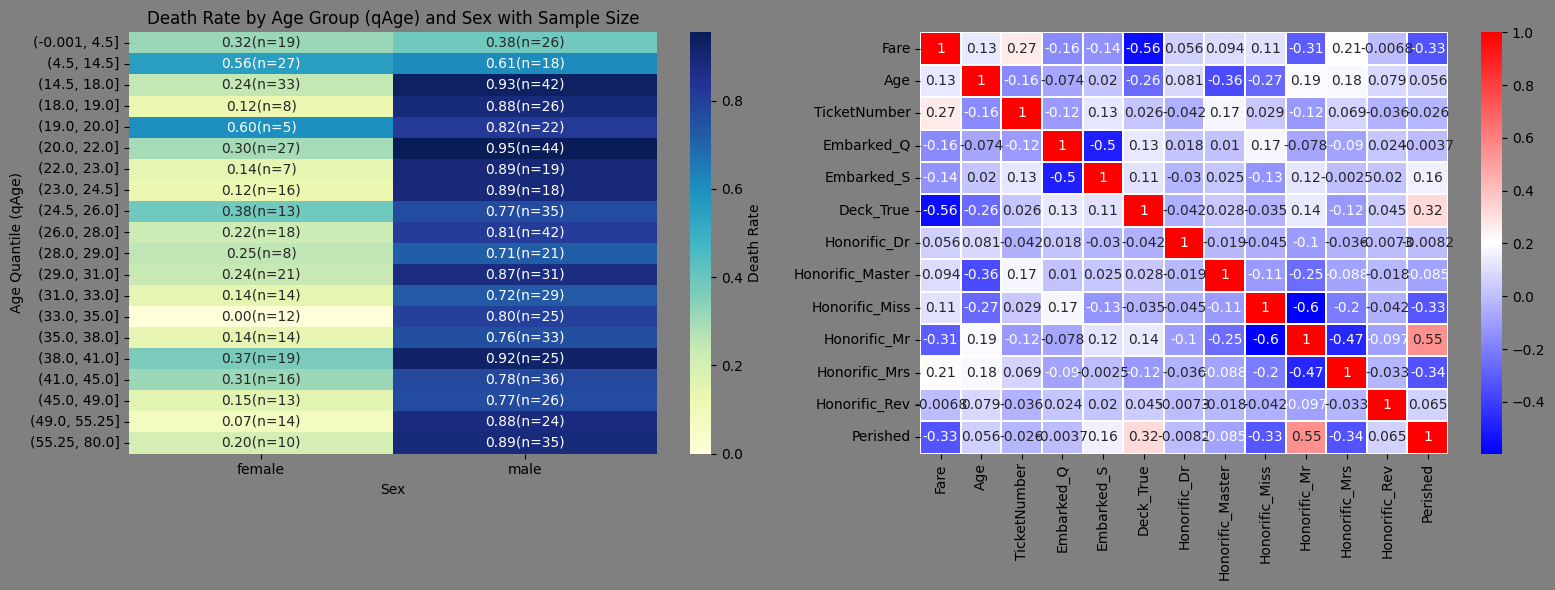

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

df_train['qAge'] = pd.qcut(df_train['Age'], 20, duplicates='drop')
death_rate = df_train.groupby(['Sex', 'qAge'], observed=False)['Perished'].mean().reset_index()
death_rate = df_train.groupby(['qAge', 'Sex'], observed=False)['Perished'].mean().reset_index()

# 死亡率と件数を集計
summary = df_train.groupby(['qAge', 'Sex'], observed=False).agg(
    death_rate=('Perished', 'mean'),
    count=('Perished', 'count')
).reset_index()

# ピボットテーブル作成（数値用とラベル用）
heatmap_values = summary.pivot(index='qAge', columns='Sex', values='death_rate')
heatmap_counts = summary.pivot(index='qAge', columns='Sex', values='count')

# アノテーション用の文字列（例: "0.75\n(n=12)"）
annot = heatmap_values.copy()
for row in annot.index:
    for col in annot.columns:
        val = heatmap_values.loc[row, col]
        cnt = heatmap_counts.loc[row, col]
        annot.loc[row, col] = f"{val:.2f}(n={cnt})"

f, ax = plt.subplots(1, 2, figsize=(16, 6), facecolor='gray')
sns.heatmap(
    heatmap_values.astype(float),  # 数値
    annot=annot,                  # アノテーション
    fmt='',                       # アノテーションに文字列を使う
    cmap='YlGnBu',
    cbar_kws={'label': 'Death Rate'},
    ax=ax[0]
)
ax[0].set_title('Death Rate by Age Group (qAge) and Sex with Sample Size')
ax[0].set_xlabel('Sex')
ax[0].set_ylabel('Age Quantile (qAge)')

sns.heatmap(df_train[[*numerical, *dum_categorical, 'Perished']].corr(),annot=True,cmap='bwr',linewidths=0.2, ax=ax[1])
plt.tight_layout()
plt.show()

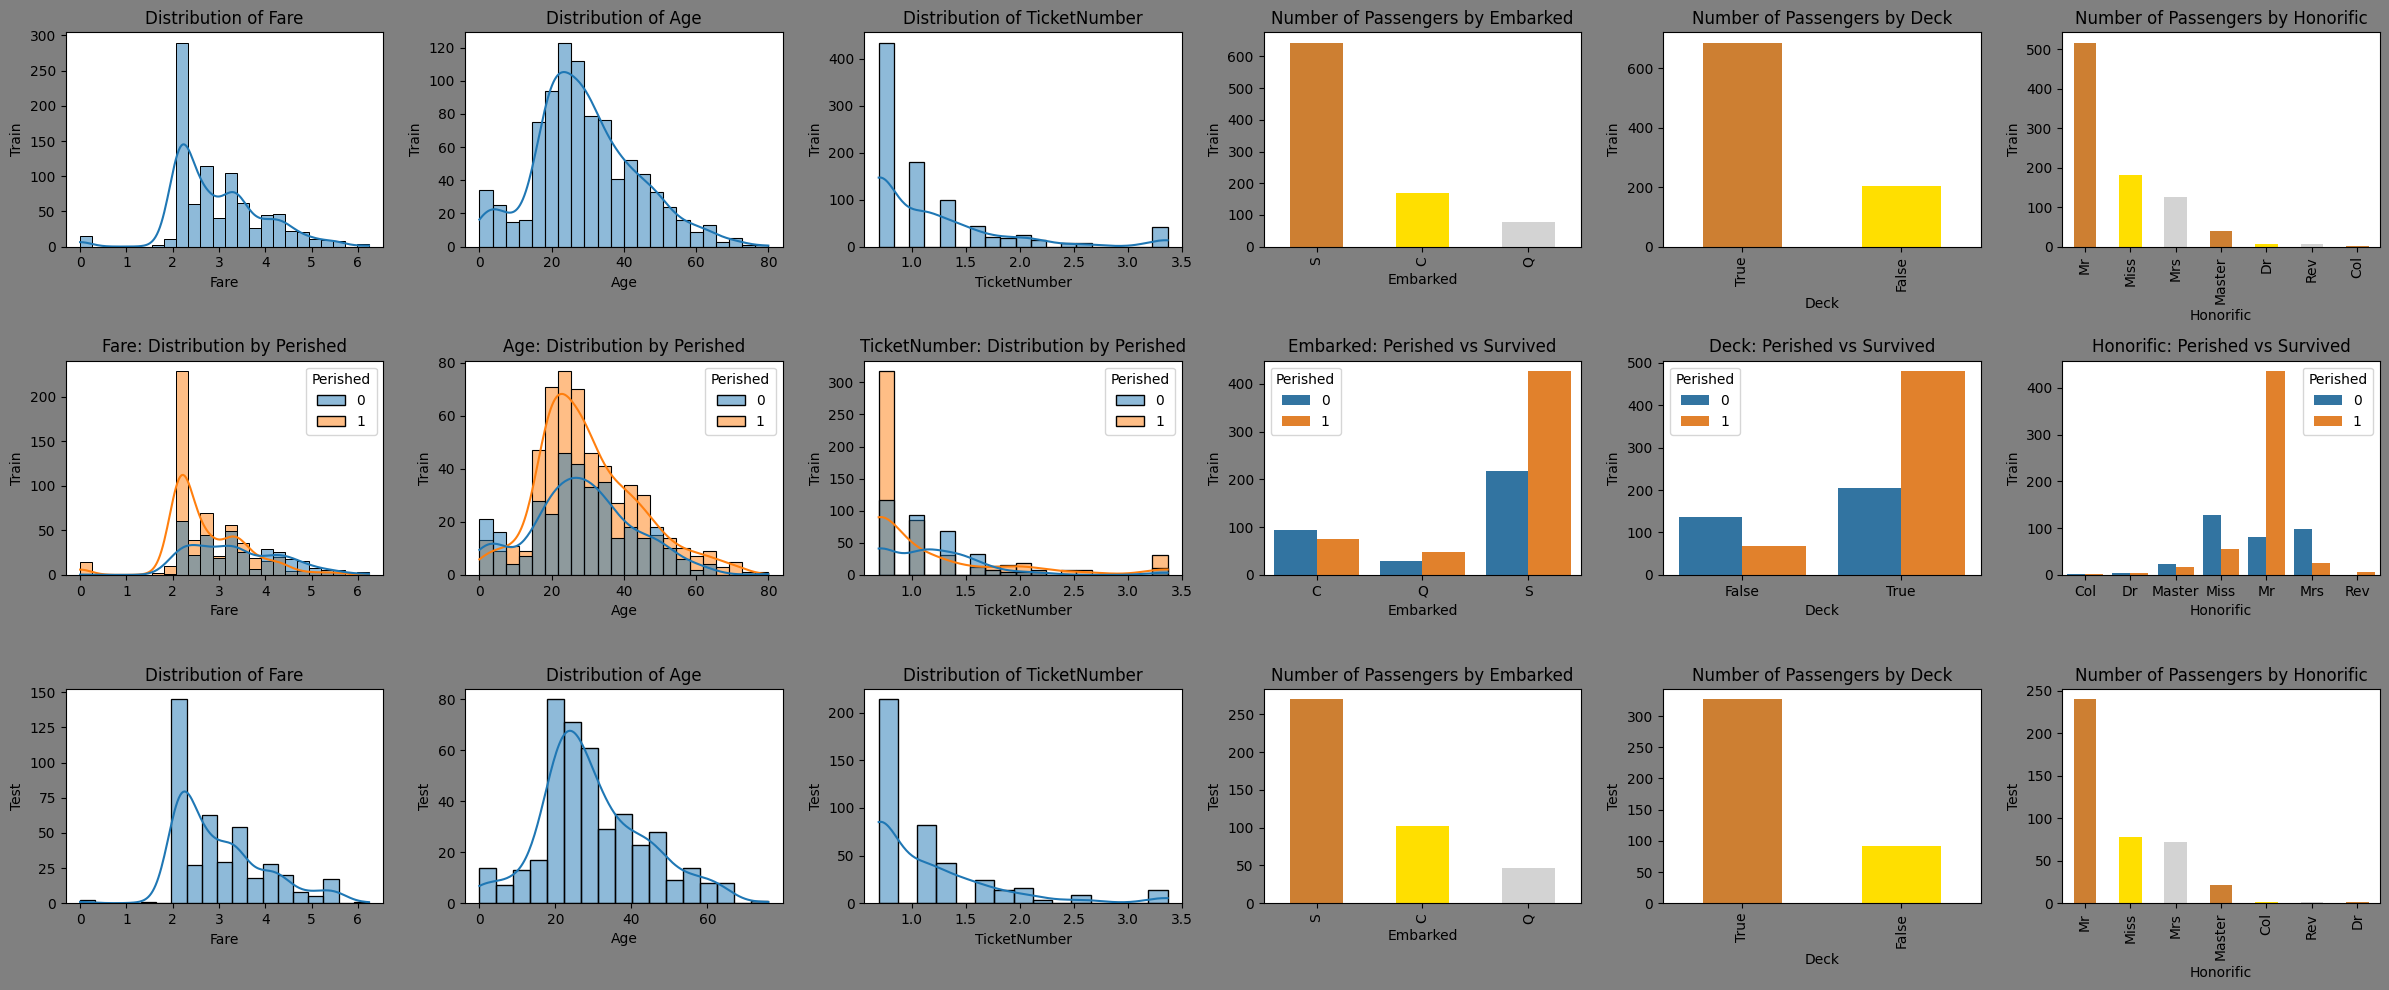

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

length = len(numerical + categorical)
f, ax = plt.subplots(3, length, figsize=(4*length, 10), facecolor='gray')
i = 0

for col in numerical + categorical:
    if col in numerical:
        # 数値列: 分布 + クラスごとの分布
        sns.histplot(df_train[col], kde=True, ax=ax[0, i], color="#1f77b4")
        ax[0, i].set_title(f'Distribution of {col}')
        ax[0, i].set_ylabel('Train')

        sns.histplot(data=df_train, x=col, hue='Perished', kde=True, ax=ax[1, i])
        ax[1, i].set_title(f'{col}: Distribution by Perished')
        ax[1, i].set_ylabel('Train')

        sns.histplot(df_test[col], kde=True, ax=ax[2, i], color="#1f77b4")
        ax[2, i].set_title(f'Distribution of {col}')
        ax[2, i].set_ylabel('Test')

        i += 1

    else:
        # カテゴリ列: 棒グラフ + クラスごとのカウント
        df_train[col].value_counts().plot.bar(
            color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[0, i]
        )
        ax[0, i].set_title(f'Number of Passengers by {col}')
        ax[0, i].set_ylabel('Train')

        sns.countplot(x=col, hue='Perished', data=df_train, ax=ax[1, i])
        ax[1, i].set_title(f'{col}: Perished vs Survived')
        ax[1, i].set_ylabel('Train')

        df_test[col].value_counts().plot.bar(
            color=['#CD7F32', '#FFDF00', '#D3D3D3'], ax=ax[2, i]
        )
        ax[2, i].set_title(f'Number of Passengers by {col}')
        ax[2, i].set_ylabel('Test')

        i += 1
    #break
plt.tight_layout()
plt.show()


In [6]:
from objective import Objective
from models import LGB, RF, CAT, LR
from params import lgb_params, rf_params, cat_params, lr_params
from sklearn.model_selection import train_test_split

X = df_train[numerical+categorical+dum_categorical]
y = df_train['Perished']
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test.columns

Index(['Fare', 'Age', 'TicketNumber', 'Embarked', 'Deck', 'Honorific',
       'Embarked_Q', 'Embarked_S', 'Deck_True', 'Honorific_Dr',
       'Honorific_Master', 'Honorific_Miss', 'Honorific_Mr', 'Honorific_Mrs',
       'Honorific_Rev'],
      dtype='object')

LightGBM

In [7]:
lgb_objective = Objective(X, y, model=LGB, params=lgb_params, numerical=numerical, categorical=categorical, n_trial=300)
lgb_objective()

  0%|          | 0/300 [00:00<?, ?it/s]

RandomForest

In [8]:
rf_objective = Objective(X, y, model=RF, params=rf_params, numerical=numerical, categorical=dum_categorical, n_trial=100)
rf_objective()

  0%|          | 0/100 [00:00<?, ?it/s]

CatBoost

In [9]:
cat_objective = Objective(X, y, model=CAT, params=cat_params, numerical=numerical, categorical=categorical, n_trial=100)
cat_objective()

  0%|          | 0/100 [00:00<?, ?it/s]

LogisticRegression

In [10]:
lr_objective = Objective(X, y, model=LR, params=lr_params, numerical=numerical, categorical=dum_categorical, n_trial=100)
lr_objective()

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
# 最適なハイパーパラメータの表示
print("Best trial:")
print(lgb_objective.study.best_trial.params)

Best trial:
{'max_depth': 5, 'num_leaves': 8, 'learning_rate': 0.09167548234571207, 'feature_fraction': 0.7940915424557135, 'bagging_fraction': 0.885148082792078, 'bagging_freq': 6, 'lambda_l1': 0.5138938934121395, 'lambda_l2': 0.7485534382731585, 'min_data_in_leaf': 83, 'n_iterations': 118}


Accuracy: 0.8212290502793296
LGB Accuracy: 0.827247191011236 , Best Score: [0.8111888111888111, 0.8531468531468531, 0.8450704225352113, 0.8098591549295775, 0.8169014084507042]
RF Accuracy: 0.8328651685393258 , Best Score: [0.8111888111888111, 0.8601398601398601, 0.8591549295774648, 0.8169014084507042, 0.8169014084507042]
CAT Accuracy: 0.8300561797752809 , Best Score: [0.8111888111888111, 0.8741258741258742, 0.8591549295774648, 0.8028169014084507, 0.8028169014084507]
LR Accuracy: 0.7907303370786517 , Best Score: [0.7692307692307693, 0.8251748251748252, 0.8028169014084507, 0.7746478873239436, 0.7816901408450704]


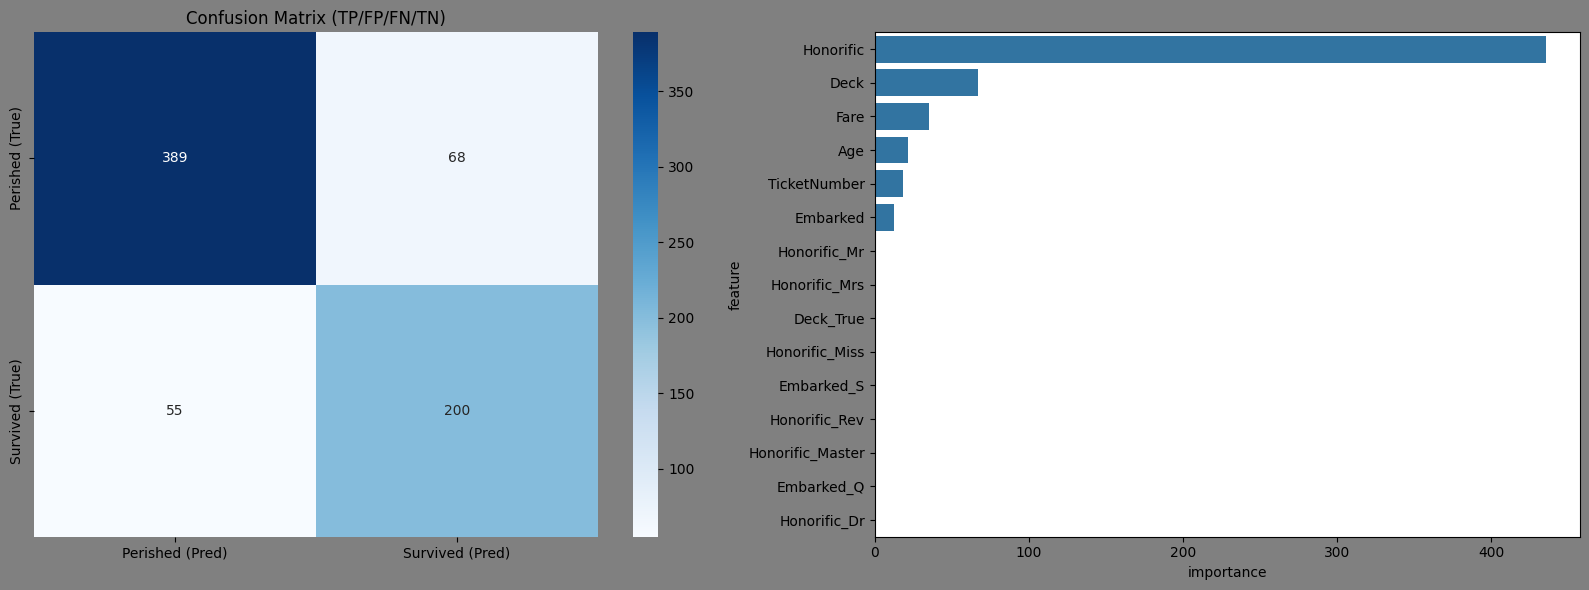

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import lightgbm as lgb

pred_prob = []
feature_importances = []
for model in lgb_objective.best_model + rf_objective.best_model + cat_objective.best_model + lr_objective.best_model:
    pred_prob.append(model.predict(X_test))
    feature_importances.append(model.feature_importance())
feature_importance = pd.concat(feature_importances)
feature_importance = feature_importance.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()

print("Accuracy:", accuracy_score(y_test, (np.mean(pred_prob, axis=0) > 0.5).astype(int)))
print("LGB Accuracy:", accuracy_score(lgb_objective.best_y_valid, (lgb_objective.best_y_pred > 0.5).astype(int)), ", Best Score:", lgb_objective.best_score)
print("RF Accuracy:", accuracy_score(rf_objective.best_y_valid, (rf_objective.best_y_pred > 0.5).astype(int)), ", Best Score:", rf_objective.best_score)
print("CAT Accuracy:", accuracy_score(cat_objective.best_y_valid, (cat_objective.best_y_pred > 0.5).astype(int)), ", Best Score:", cat_objective.best_score)
print("LR Accuracy:", accuracy_score(lr_objective.best_y_valid, (lr_objective.best_y_pred > 0.5).astype(int)), ", Best Score:", lr_objective.best_score)

tn, fp, fn, tp = confusion_matrix(lgb_objective.best_y_valid, (lgb_objective.best_y_pred > 0.5).astype(int)).ravel()

df_conf = pd.DataFrame(
    [[tp, fp],
     [fn, tn]],
    index=["Perished (True)", "Survived (True)"],
    columns=["Perished (Pred)", "Survived (Pred)"]
)

f, ax = plt.subplots(1, 2, figsize=(16, 6), facecolor='gray')
sns.heatmap(df_conf, annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Confusion Matrix (TP/FP/FN/TN)")

sns.barplot(feature_importance, x='importance', y='feature', ax=ax[1])
plt.tight_layout()
plt.show()


In [13]:
pred_prob = []
for model in lgb_objective.best_model + rf_objective.best_model + cat_objective.best_model + lr_objective.best_model:
    pred_prob.append(model.predict(df_test[numerical+categorical+dum_categorical]))
pred = (np.mean(pred_prob, axis=0) > 0.5).astype(int)
print(f'Perished rate: {np.count_nonzero(pred==1)/len(pred)}')
submission = pd.read_csv('../gender_submission.csv')
submission['Perished'] = pred
submission

Perished rate: 0.6124401913875598


,PassengerId,Perished
0,892,1
1,893,0
2,894,1
3,895,1
4,896,0
...,...,...
413,1305,1
414,1306,0
415,1307,1
416,1308,1


In [14]:
submission.to_csv('../submission.csv',index=False)